# Udacity capstone project - Cancer classification using CNN's

## Project description 

#### The aim of this project to build a model that can predict if images show cancerous tissue samples are not. As you will no doubt be aware, cancer is one of the leading causes of mortality in the developed world. Simultaneously, many western societies are facing ageing populations and a shortage of medical professionals. Against this background there are clear benefits to using automated methods of processing diagnostic images - although these should be complements to - and not substitutes for - medical expertise and professional judgement.

#### This project will work with data on Invasive Ductal Carcinoma (IDC) -a form of breast cancer-  taken from the kaggle page here: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images. The data consists of images, each showing a 50 x 50 pixel region from a breast scan. I will process the data for analysis and then build a model that can distinguish cancerous sub-samples from non-cancerous ones. 

#### In this project I use a deep learning model that utilises Convolution Neural Networks (CNN's). A major advantage of working with CNN's is that they are the industry standard for computer vision and thus there are many tools predeicated on this method, with helpful documentation. Furthermore, they are designed specifically for image analysis. However, there are some alternative methods that I decided not to use. 
- One option is to use Recurrent Neural Networks, however these are more appropriate for sequences of information (i.e. there is a temporal dimension). This is why they are frequently used for tasks such as translation - where the order of the information is crucial to its meaning - and analysing videos whereas my data consists of non-sequential photos. Recurrent Neural Networks are also slower than CNN's, which could be an issue given that my final model will use a lot of data.
- Restricted Boltzman models are another option that didn't seem appropriate for this task. This approach appears to be used more for modelling systems using unsupervised learning, although I understand that they can be used for classification tasks. With the data set used in this project labels are available, allowing us to train the model with supervised learning methods, which tend to be more accurate (if interested you can see the discussion here: https://www.ibm.com/cloud/blog/supervised-vs-unsupervised-learning#:~:text=While%20supervised%20learning%20models%20tend,weather%20conditions%20and%20so%20on.)

#### In this notebook I will explore the data, prepare it for analysis and build a model. Building CNN's and tuning parameters is a process that requires logic but also some trial and error to find the model that's most appropriate to the data. As such, in this notebook I will work with a small subset of all the data available (around 1200 images). I will then run several models to find the best parameters and model architecture. I will explain my thinking to justify modifications to model hyperparameters as I go through the iterations.

### Packages


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 

#tf.keras.preprocessing.image.array_to_img

### Read in data 

#### A point to note here is that the data is organised by its author in a way that makes it easier to manage computationally, however the way this has been done means that each folder ID is not unique to one patient (see this post https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/discussion/137446) . As a result, this notebook contains terms like 'pseudopatient' to reflect the fact the process being carried out would be useful when looking at individual patients, but that we cannot make inferences about individual patients based on this data.

#### The cells below does a few things, so let's break them down.

#### In our data set each pseudopatient has their own folder containing two subfolders - one with non-cancerous samples (class0) and one with cancerous samples (class1). The first loop below uses os.walk() to iterate through the folders and subfolders to create a list of all the file names - called image_paths.

#### The second loop goes through all of the filenames in image_path and for each one reads in the corresponding image file and saves it in a list called 'images'

In [2]:
root_dir = 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder'
image_paths = []
images = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        image_paths.append(full_path)

In [3]:
for image_path in image_paths:
    try:
        img = Image.open(image_path)
        images.append(img)
    except IOError:
        print(f"Error: Could not read image {image_path}")

In [4]:
images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2663E4265B0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2663E426970>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D1670>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D15B0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D16D0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D1730>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D1790>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D17F0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D1850>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D18B0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D1910>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2664D4D1970>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB siz

In [5]:
len(images)

1249

In [6]:
image_paths

['D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1001_y1301_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1001_y1351_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1251_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1301_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1351_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1401_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1451_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1101_y1301_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_f

In [7]:
len(image_paths)

1249

### Preparing the data

#### In this section we will:
- Check if the dimensions of the images are consistent and either resize or drop images as necessary.
- Create our classes data


#### Lets's check out the first image in the dataset as an example

In [8]:
example_image = images[0]

height = example_image.height
width = example_image.width

print('image height and width:', height, width) # looks good

image height and width: 50 50


#### Now let's analyse all of the images. Note that the values returned are the index values for the images with dimensions other than 50 x 50. We can use this to see how many images deviate from the 50x50 dimensions.


In [9]:
heights_list = []
widths_list = []

for img in images:
    heights_list.append(img.height)
    widths_list.append(img.width)

deviant_heights = [index for (index, item) in enumerate(heights_list) if item != 50]

print(deviant_heights)

[325]


#### Scrolling through the list of images there is one that has dimensions 50 x 1. This is possibly an error in data generation as the image is only one pixel tall. Now let's check the widths.

In [10]:
deviant_widths = [index for (index, item) in enumerate(widths_list) if item != 50]

print(deviant_widths)

[744, 745, 746]


#### Scrolling through the images list again these three images have dimensions 42x50 so are likely still useful.

#### At this point we want to remove the 50 x 1 and resize the 42 x 50 images. However, thinking ahead if we remove the 50 x 1 image without removing it's corresponding file path in the image_paths list then this will lead to the images and classes data sets being inconsistent with each other. Let's remove the image path corresponding to the 50 x 1 image

In [11]:
# Create a dictionary mapping images to file paths
image_file_dict = dict(zip(map(str, images), image_paths))

# Remove images from the data set
filtered_images = [img for img in images if img.height >= 40]

# Remove the corresponding file paths from the file_paths list
filtered_paths = [image_file_dict[str(image)] for image in filtered_images]


In [12]:
len(filtered_images)

1248

In [13]:
len(filtered_paths)

1248

#### Now to resize the remaining images

In [14]:
resized_images = []

for img in filtered_images:
    resz = img.resize((50, 50))
    resized_images.append(resz)

In [15]:
len(resized_images)

1248

#### We can repeat the process above to see if we have any images that aren't 50 x50

In [16]:
heights_list = []
widths_list = []

for img in resized_images:
    heights_list.append(img.height)
    widths_list.append(img.width)

deviant_heights = [index for (index, item) in enumerate(heights_list) if item != 50]

print(deviant_heights)

[]


In [17]:
deviant_widths = [index for (index, item) in enumerate(widths_list) if item != 50]

print(deviant_widths)

[]


#### Great! Now we're ready to create the classes data which will provide out labels in the CNN model.

#### For each image we want to know the class; 0 for non-cancerous or 1 for cancerous. As this information is in the file names, we can get this by iterating through the strings in the file names and extracting the fifth-from-last digit. The data is then saved in a list called 'classes'

In [18]:
classes = []

for name in filtered_paths:
    diagnosis = name[-5]
    classes.append(diagnosis)

In [19]:
classes

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0'

In [20]:
len(classes)

1248

### Understanding the data

#### Now let's try to understand the data a bit better. In this section I will:
- Compare the number of cancerous and non-cancerous samples in our data set and check the data is a balanced.
- See if the number of samples is consistent across pseudopatients. If this code ever gets applied to data with individual patient ID's then this would be a nice check to include.
- Actually look at the images we have to get an idea of distinguishes cancerous and non-cancerous samples

#### To see if the labels data is balanced, I will make the classes variable into a pandas dataframe and use the value_counts method.

In [21]:
diagnosis_df= pd.DataFrame({'class': classes})

In [22]:
diagnosis_df.head()

class
0     0
1     0
2     0
3     0
4     0

In [23]:
len(diagnosis_df)

1248

<AxesSubplot:xlabel='class'>

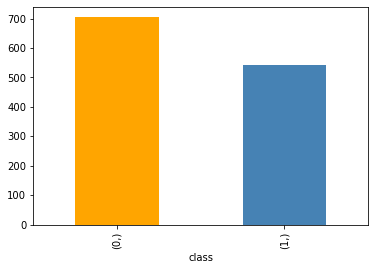

In [24]:
colors = ['orange', 'steelblue']
diagnosis_df.value_counts().plot(kind='bar', color=colors)

In [25]:
diagnosis_df.value_counts()

class
0        704
1        544
dtype: int64

#### In our data we have a small majority of non-cancerous samples, though this looks like there are enough observations in each class for a model to be trained on the data. Now as a quick QA, let's see if the number of samples is similar for each 'patient'. Given the previous discussion about how each ID doesn't reflect a unique patient in this data set we don't need to worry if there is an imbalance, but in reality this could provide a useful check that health practitioners have carried out the data generating process correctly.

#### Originally I intended to extract ID numbers from the file names using slicing again. However the file names are of different lengths, meaning that using regular expressions was a better approach here

In [26]:
pattern = r"\\(\d+)_"
id = []

for name in image_paths:
    match = re.search(pattern, name)
    if match:
        id_number = match.group(1)
        id.append(id_number)


In [27]:
id

['12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',


In [28]:
id = pd.DataFrame({'id_no': id})

In [29]:
id

id_no
0     12241
1     12241
2     12241
3     12241
4     12241
...     ...
1244  12242
1245  12242
1246  12242
1247  12242
1248  12242

[1249 rows x 1 columns]

In [30]:
id.value_counts()

id_no
12242    1097
12241     152
dtype: int64

#### To get an idea of what kind of images we're dealing with, let's plot a few. Below we have 4 non-cancerous samples and 4 cancerous ones. At a glance there are some differences - for example the cancerous samples tend to have denser blocks of darker pixels, whereas the non-cancerous ones tend to have swirls or abstract patterns to them. However, looking at the right-most non-cancerous sample, this has some characteristics of a cancerous sample. For a experienced professional it might be possible to reliably distinguish between the classes by looking at the images, though I doubt many other people could.

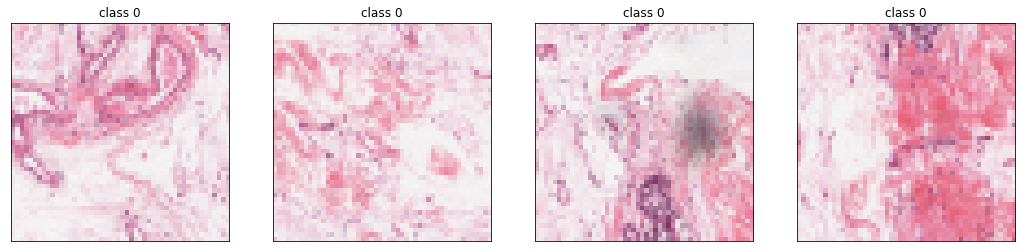

In [31]:
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

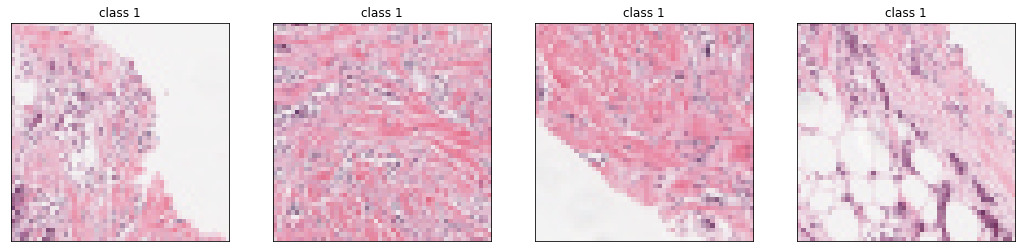

In [32]:
fig = plt.figure(figsize=(18,18))
for i in range(51, 55):
    ax = fig.add_subplot(1, 4, i - 50, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

## Modelling

#### In this section I will:
- Perform some final checks on my data
- Create my training and test data sets
- Run a simple model which I will then refine to find the best performing interation of the model

#### Both inputs need to be defined as np arrays

In [33]:
classes = np.array(classes)
classes= classes.astype(int)

In [34]:
image_data = np.array([image.img_to_array(img) for img in resized_images])

In [35]:
type(classes)

numpy.ndarray

In [36]:
classes

array([0, 0, 0, ..., 1, 1, 1])

In [133]:
classes.dtype

dtype('int32')

In [38]:
np.unique(classes)

array([0, 1])

In [39]:
# Vanishing gradients need to be considered

#### Create training, validation and test datasets. Note that I am using train_test_split twice here. Once to create the train and test data, then a second time to allocate some of the training data to a validation set that can be used to monitor how well the model generalises to unseen data in each training epoch. I have used the random_state parameter to ensure the same images are allocated to each dataset whenever this code is run.

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split (image_data, classes, test_size = 0.3, random_state=101)

In [41]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=101)

In [42]:
len(image_data)

1248

In [43]:
len(X_test)

375

In [44]:
len(X_train)

698

In [45]:
len(X_val)

175

In [46]:
len(Y_train)

698

In [47]:
len(Y_test)

375

In [48]:
len(Y_val)

175

In [49]:
X_shape = X_train.shape

#### Build model - below is about the most basic model that can be used for this problem. Maybe its also the most appropriate, but that needs to be tested.

#### A note on some of the hyperparameters chosen. A heuristic that I came across for size of the filter in the convolutional layer is that if you think model needs to learn small details then you need smaller filters. However if identifying broader features will do the trick then can use a larger filter. In this case the images are relatively low res, plus the difference  between a cancerous and non-cancerous sample seems to be a matter of broad patterns, thus I have selected a relatively large window size.
#### I've also started with 16 filters as these should cover most basic shapes and blob detection, however I will experiment with this hyperparameter later.

In [50]:
model = Sequential()
model.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same', 
                 activation = 'relu')) 
model.add(MaxPool2D (pool_size = 2,
                    strides = (2,2),
                    padding = 'same'))
model.add(Flatten())
model.add(Dense(250, activation = 'relu', input_shape = X_shape))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

#### Compiling the model
#### I have selected binary cross entropy as this is the appropriate loss function for binary classification tasks. 'Adam' is a decent all-purpose optimizer so worth trying initially. It is possible to have sparse data from our images so can then compare to using rmsprop, which is well suited to such data

In [51]:
model.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )

#### Fit model

In [52]:
model.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val))

Epoch 1/50
22/22 [==============================] - 1s 24ms/step - loss: 38.8076 - accuracy: 0.5430 - val_loss: 0.8722 - val_accuracy: 0.5657
Epoch 2/50
22/22 [==============================] - 0s 12ms/step - loss: 0.9245 - accuracy: 0.5645 - val_loss: 0.7578 - val_accuracy: 0.5829
Epoch 3/50
22/22 [==============================] - 0s 11ms/step - loss: 0.6799 - accuracy: 0.6447 - val_loss: 0.7383 - val_accuracy: 0.5429
Epoch 4/50
22/22 [==============================] - 0s 12ms/step - loss: 0.5910 - accuracy: 0.6719 - val_loss: 0.6531 - val_accuracy: 0.6857
Epoch 5/50
22/22 [==============================] - 0s 10ms/step - loss: 0.5396 - accuracy: 0.7364 - val_loss: 0.7079 - val_accuracy: 0.6457
Epoch 6/50
22/22 [==============================] - 0s 10ms/step - loss: 0.4764 - accuracy: 0.7765 - val_loss: 0.6923 - val_accuracy: 0.6514
Epoch 7/50
22/22 [==============================] - 0s 10ms/step - loss: 0.4459 - accuracy: 0.7779 - val_loss: 0.6806 - val_accuracy: 0.6743
Epoch 8/50
2

#### Below I have plotted out metric for model performance in each epoch of training. In the top diagram we have the training loss and validation loss for each epoch. Below that is a similar figure for accuracy.

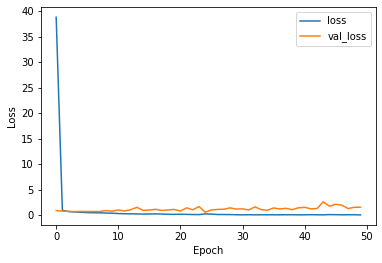

In [54]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

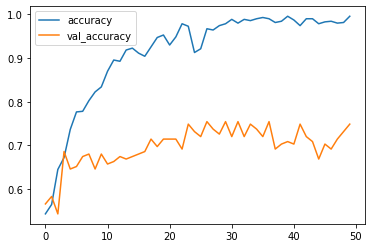

In [55]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
plt.show()

In [56]:
adam_score  = model.evaluate(X_test, Y_test, verbose = 0)
print(adam_score[1])

0.7066666483879089


#### The accuracy score is decent ,however for use in a clincal setting we would want something higher than this. Furthermore the behaviour of the loss and validation loss aren't ideal. Really we would want to see them both track downwards with each epoch, showing that the model is learning. Instead the loss crashes then stagnates, while the validation loss actually rises with each epoch. This suggests that the model is not learning well and may be using noise / irrelevant features to predict values. Below I explore some ways of trying to improve the models performance.

## Improving the model

#### So far we have a model, but it isn't an awful lot better than a coin flip. In this section look at two ways to improve the accuracy of the model:
- 1) Add variation (and hence information) to our data set using data augmentation
- 2) Play around with various parameters in the architecture and see if this improves performance
 

### Data augmentation

#### Let's look at doing data augmentation then adjusting the model hyperparameters. Data Augmentation is a process where the image data has things done to it like zooming in/out, random rotations or random flips. The idea is to create more variation in the data, thus creating learning opportunities for the model. I'd like to note that I use a different approach to that shown in the course. Official tensorflow documentation (see link below) states that ImageDataGenerator is not recommended for new code, and that instead preprocessing layers are recommended.  
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

#### I have followed the preprocessing layers approach, and found the documentation below pretty helpful
- https://www.tensorflow.org/tutorials/images/data_augmentation

#### This site gives a useful list of the different layers available - including the augmentations that you can do:
- https://www.tensorflow.org/api_docs/python/tf/keras/layers

#### In the cell below I define the manipulations that I want done on the images. Here I have chosen to start simple and use random horizontal and vertical flips, as well as rescaling.

In [63]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
layers.Rescaling( 1/255)])

#### Let's apply the augmentation to each image in turn and save the new image in the 'augmented_images' variable

In [64]:
augmented_images = []
for image in resized_images:
    augmented_image = augmentation(image)
    augmented_images.append(augmented_image)

In [65]:
augmented_images

[<tf.Tensor: shape=(50, 50, 3), dtype=float32, numpy=
 array([[[0.9450981 , 0.86274517, 0.89019614],
         [0.9450981 , 0.9058824 , 0.9333334 ],
         [0.9568628 , 0.9215687 , 0.93725497],
         ...,
         [0.9490197 , 0.9058824 , 0.9294118 ],
         [0.95294124, 0.94117653, 0.93725497],
         [0.9568628 , 0.93725497, 0.9490197 ]],
 
        [[0.9333334 , 0.854902  , 0.8980393 ],
         [0.8588236 , 0.74509805, 0.8078432 ],
         [0.9450981 , 0.909804  , 0.93725497],
         ...,
         [0.95294124, 0.94117653, 0.94117653],
         [0.95294124, 0.95294124, 0.9450981 ],
         [0.95294124, 0.909804  , 0.92549026]],
 
        [[0.9686275 , 0.9058824 , 0.9333334 ],
         [0.909804  , 0.8352942 , 0.882353  ],
         [0.9333334 , 0.854902  , 0.882353  ],
         ...,
         [0.9568628 , 0.94117653, 0.95294124],
         [0.95294124, 0.9450981 , 0.95294124],
         [0.95294124, 0.909804  , 0.9294118 ]],
 
        ...,
 
        [[0.8431373 , 0.7137255 , 

In [66]:
type(augmented_images)

list

#### The augmented_images data is effectively a set of arrays - OR TENSORS, meaning that we can pass this to a CNN model. However, it would be nice to see what has been done to the images and compare them to the original images. To do this we need to turn the convert our arrays in 'augmented_images' back into image files.

In [67]:
# Convert augmented images back to numpy array if needed
augmented_array = [x.numpy() for x in augmented_images]

In [68]:
augmented_array

[array([[[0.9450981 , 0.86274517, 0.89019614],
         [0.9450981 , 0.9058824 , 0.9333334 ],
         [0.9568628 , 0.9215687 , 0.93725497],
         ...,
         [0.9490197 , 0.9058824 , 0.9294118 ],
         [0.95294124, 0.94117653, 0.93725497],
         [0.9568628 , 0.93725497, 0.9490197 ]],
 
        [[0.9333334 , 0.854902  , 0.8980393 ],
         [0.8588236 , 0.74509805, 0.8078432 ],
         [0.9450981 , 0.909804  , 0.93725497],
         ...,
         [0.95294124, 0.94117653, 0.94117653],
         [0.95294124, 0.95294124, 0.9450981 ],
         [0.95294124, 0.909804  , 0.92549026]],
 
        [[0.9686275 , 0.9058824 , 0.9333334 ],
         [0.909804  , 0.8352942 , 0.882353  ],
         [0.9333334 , 0.854902  , 0.882353  ],
         ...,
         [0.9568628 , 0.94117653, 0.95294124],
         [0.95294124, 0.9450981 , 0.95294124],
         [0.95294124, 0.909804  , 0.9294118 ]],
 
        ...,
 
        [[0.8431373 , 0.7137255 , 0.7803922 ],
         [0.909804  , 0.7960785 , 0.85490

In [69]:
type(augmented_array)

list

In [70]:
# Convert 
converted_images = []

for img in augmented_array:

 image = tf.keras.preprocessing.image.array_to_img(img) 
 converted_images.append(image)

In [71]:
converted_images

[<PIL.Image.Image image mode=RGB size=50x50 at 0x266563284F0>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656328A30>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26655E9DEB0>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26655E9D040>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391640>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391340>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391460>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391D90>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391610>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391100>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391130>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391DC0>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x266563919D0>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391EB0>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x26656391A00>,
 <PIL.Image.Image image mode=RGB size=50x50 at 0x266563

In [72]:
type(converted_images)

list

#### Now we can visualise both sets of images!

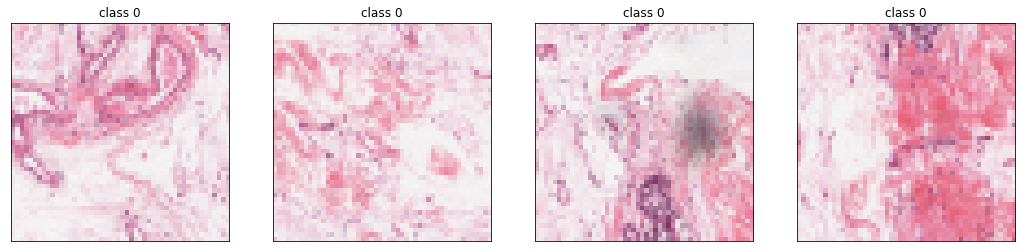

In [73]:
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

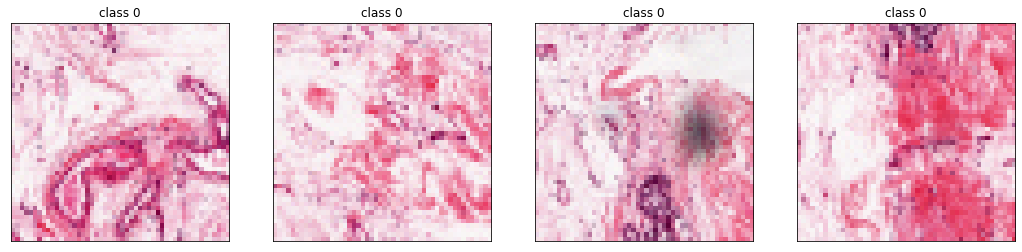

In [74]:
# Note that the augmentation process can drastically alter the pixel values, so need to normalise images

fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    #normalized_image = exposure.rescale_intensity(augmented_images[i], out_range=(0, 1))
    ax.imshow(converted_images[i])
    ax.set_title('class {}'.format(classes[i]))

#### Above we can see our orignal images (top) and the augmented images (below). The augmented images are recognisable as the originals but flipped. The new images also have a sharper contrast between the lighter and darker regions of the image - possibly due to the rescaling. Now it's time to use this data in a model!

#### Define training and test data, input shape and double check data is in np.array format

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split (augmented_images, classes, test_size = 0.3, random_state=101)

In [76]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state= 101)

In [77]:
X_train = np.array(X_train)

In [78]:
X_train.shape

(698, 50, 50, 3)

In [79]:
X_Shape = X_train.shape

In [80]:
type(X_train)

numpy.ndarray

#### As a a quick QA of the training data, let's see if the labels are reasonably balance within the training data.

In [135]:
QA_train = pd.DataFrame(Y_train)

In [136]:
QA_train.value_counts()

0    394
1    304
dtype: int64

#### Seems ok.

In [81]:
X_test=np.array(X_test)

In [82]:
X_test.shape

(375, 50, 50, 3)

In [83]:
X_val = np.array(X_val)

In [84]:
X_val.shape

(175, 50, 50, 3)

#### Try out models using the augmented data

In [85]:
model2 = Sequential()
model2.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model2.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model2.add(Flatten())
model2.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation = 'sigmoid'))

In [86]:
model2.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model2.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val))

Epoch 1/50
22/22 [==============================] - 1s 23ms/step - loss: 0.8685 - accuracy: 0.5315 - val_loss: 0.6920 - val_accuracy: 0.5371
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.6848 - accuracy: 0.5602 - val_loss: 0.6899 - val_accuracy: 0.5371
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.6807 - accuracy: 0.5630 - val_loss: 0.6893 - val_accuracy: 0.5371
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.6777 - accuracy: 0.5645 - val_loss: 0.6882 - val_accuracy: 0.5371
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.6671 - accuracy: 0.5831 - val_loss: 0.6863 - val_accuracy: 0.5371
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.6462 - accuracy: 0.5931 - val_loss: 0.6533 - val_accuracy: 0.5657
Epoch 7/50
22/22 [==============================] - 0s 13ms/step - loss: 0.6531 - accuracy: 0.6032 - val_loss: 0.6660 - val_accuracy: 0.4914
Epoch 8/50
22

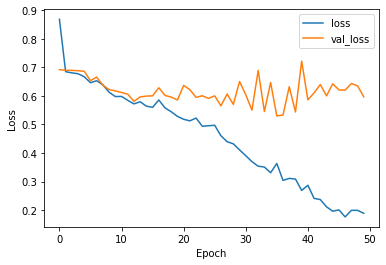

In [87]:
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

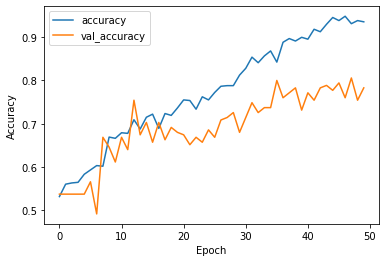

In [88]:
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [89]:
aug_score  = model2.evaluate(X_test, Y_test, verbose = 0)
print(aug_score[1])

0.7706666588783264


#### This is clearly an improvement compared to running this architecture on the original data. Not only is the accuracy score higher, but the charts above suggest that the model is learning between epochs, although the performance on the validation data plateaus quite early on.

#### Let's try running this model after defining a batch size 

In [92]:
model3 = Sequential()
model3.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model3.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model3.add(Flatten())
model3.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation = 'sigmoid'))

In [93]:
model3.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model3.fit(X_train, Y_train, epochs =50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 33ms/step - loss: 0.7219 - accuracy: 0.5258 - val_loss: 0.6863 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 18ms/step - loss: 0.6529 - accuracy: 0.5817 - val_loss: 0.6447 - val_accuracy: 0.6800
Epoch 3/50
14/14 [==============================] - 0s 19ms/step - loss: 0.6256 - accuracy: 0.6648 - val_loss: 0.6558 - val_accuracy: 0.5943
Epoch 4/50
14/14 [==============================] - 0s 18ms/step - loss: 0.6527 - accuracy: 0.6246 - val_loss: 0.6412 - val_accuracy: 0.6114
Epoch 5/50
14/14 [==============================] - 0s 18ms/step - loss: 0.6409 - accuracy: 0.6203 - val_loss: 0.6389 - val_accuracy: 0.6343
Epoch 6/50
14/14 [==============================] - 0s 18ms/step - loss: 0.6099 - accuracy: 0.6676 - val_loss: 0.6262 - val_accuracy: 0.6514
Epoch 7/50
14/14 [==============================] - 0s 18ms/step - loss: 0.5874 - accuracy: 0.6934 - val_loss: 0.5763 - val_accuracy: 0.7257
Epoch 8/50
14

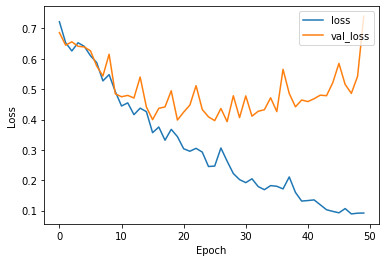

In [94]:
plt.plot(model3.history.history['loss'])
plt.plot(model3.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

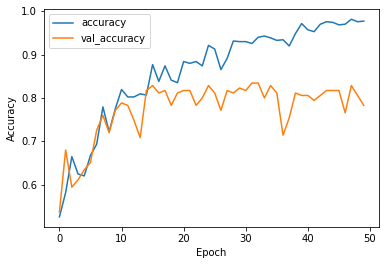

In [95]:
plt.plot(model3.history.history['accuracy'])
plt.plot(model3.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [96]:
mod3 = model3.evaluate(X_test, Y_test, verbose = 0)
print(mod3[1]) # No difference to model 2

0.8053333163261414


#### Let's try adding more convolutional layers to see if more information can be extracted - I fought it difficult to find a heuristic for number of layers so need to experiment a bit

In [98]:
model4 = Sequential()
model4.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model4.add(Conv2D(filters = 16,  
                 kernel_size = 3, #note that the map here is smaller than above 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model4.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model4.add(Flatten())
model4.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model4.add(Dropout(0.3))
model4.add(Dense(1, activation = 'sigmoid'))

In [99]:
model4.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model4.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 2s 39ms/step - loss: 0.6810 - accuracy: 0.5473 - val_loss: 0.6757 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 22ms/step - loss: 0.6701 - accuracy: 0.5645 - val_loss: 0.6701 - val_accuracy: 0.5371
Epoch 3/50
14/14 [==============================] - 0s 24ms/step - loss: 0.6467 - accuracy: 0.5716 - val_loss: 0.6527 - val_accuracy: 0.5714
Epoch 4/50
14/14 [==============================] - 0s 20ms/step - loss: 0.6264 - accuracy: 0.6361 - val_loss: 0.6335 - val_accuracy: 0.6514
Epoch 5/50
14/14 [==============================] - 0s 21ms/step - loss: 0.6151 - accuracy: 0.6762 - val_loss: 0.6282 - val_accuracy: 0.6457
Epoch 6/50
14/14 [==============================] - 0s 19ms/step - loss: 0.6110 - accuracy: 0.6633 - val_loss: 0.6780 - val_accuracy: 0.6457
Epoch 7/50
14/14 [==============================] - 0s 20ms/step - loss: 0.5963 - accuracy: 0.6805 - val_loss: 0.6414 - val_accuracy: 0.6800
Epoch 8/50
14

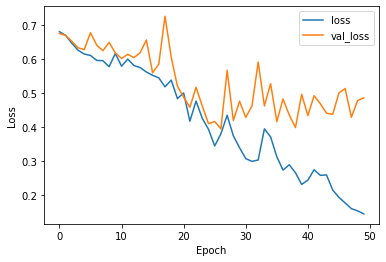

In [100]:
plt.plot(model4.history.history['loss'])
plt.plot(model4.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

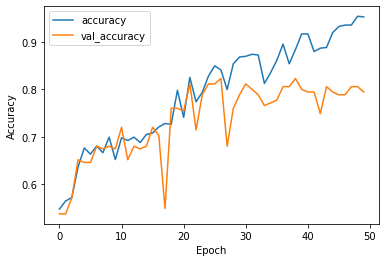

In [101]:
plt.plot(model4.history.history['accuracy'])
plt.plot(model4.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [102]:
mod4 = model4.evaluate(X_test, Y_test, verbose = 0)
print(mod4[1])

0.8159999847412109


#### Would the model perform better with more filters? Note that there are diminishing returns to more filters and could just slow down processing

In [104]:
model5 = Sequential()
model5.add(Conv2D(filters = 25,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model5.add(Conv2D(filters = 25,  
                 kernel_size = 3, #note that the map here is smaller than above 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model5.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model5.add(Flatten())
model5.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model5.add(Dropout(0.3))
model5.add(Dense(1, activation = 'sigmoid'))

In [105]:
model5.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model5.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 39ms/step - loss: 0.6822 - accuracy: 0.5458 - val_loss: 0.6761 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 23ms/step - loss: 0.6579 - accuracy: 0.5616 - val_loss: 0.6565 - val_accuracy: 0.4914
Epoch 3/50
14/14 [==============================] - 0s 21ms/step - loss: 0.6307 - accuracy: 0.6304 - val_loss: 0.6537 - val_accuracy: 0.6057
Epoch 4/50
14/14 [==============================] - 0s 21ms/step - loss: 0.6176 - accuracy: 0.6390 - val_loss: 0.6315 - val_accuracy: 0.6800
Epoch 5/50
14/14 [==============================] - 0s 21ms/step - loss: 0.6081 - accuracy: 0.6777 - val_loss: 0.6159 - val_accuracy: 0.6343
Epoch 6/50
14/14 [==============================] - 0s 21ms/step - loss: 0.5920 - accuracy: 0.6819 - val_loss: 0.6185 - val_accuracy: 0.6343
Epoch 7/50
14/14 [==============================] - 0s 21ms/step - loss: 0.6386 - accuracy: 0.6562 - val_loss: 0.6144 - val_accuracy: 0.6400
Epoch 8/50
14

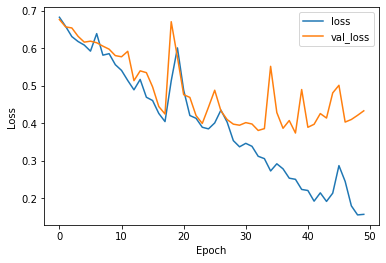

In [106]:
plt.plot(model5.history.history['loss'])
plt.plot(model5.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

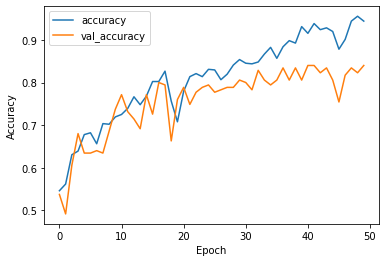

In [107]:
plt.plot(model5.history.history['accuracy'])
plt.plot(model5.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [108]:
mod5 = model5.evaluate(X_test, Y_test, verbose = 0)
print(mod5[1]) #this is a bit worse than the previous model 

0.7760000228881836


#### Lets reset the number of filters in each convolutional layer and see if the dropout layer before the output is helping

In [110]:
model6 = Sequential()
model6.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model6.add(Conv2D(filters = 16,  
                 kernel_size = 3, #note that the map here is smaller than above 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model6.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model6.add(Flatten())
model6.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model6.add(Dense(1, activation = 'sigmoid'))

In [111]:
model6.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model6.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 27ms/step - loss: 0.6893 - accuracy: 0.5530 - val_loss: 0.6845 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6748 - accuracy: 0.5645 - val_loss: 0.6855 - val_accuracy: 0.5371
Epoch 3/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6698 - accuracy: 0.5616 - val_loss: 0.6731 - val_accuracy: 0.5371
Epoch 4/50
14/14 [==============================] - 0s 15ms/step - loss: 0.6659 - accuracy: 0.5731 - val_loss: 0.6699 - val_accuracy: 0.6114
Epoch 5/50
14/14 [==============================] - 0s 15ms/step - loss: 0.6466 - accuracy: 0.5716 - val_loss: 0.6507 - val_accuracy: 0.6114
Epoch 6/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6550 - accuracy: 0.6504 - val_loss: 0.6418 - val_accuracy: 0.7600
Epoch 7/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6337 - accuracy: 0.6705 - val_loss: 0.6220 - val_accuracy: 0.6171
Epoch 8/50
14

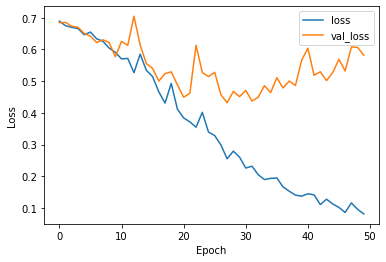

In [112]:
plt.plot(model6.history.history['loss'])
plt.plot(model6.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

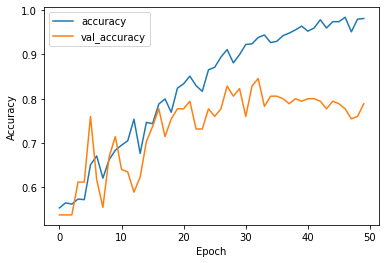

In [113]:
plt.plot(model6.history.history['accuracy'])
plt.plot(model6.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [114]:
mod6 = model6.evaluate(X_test, Y_test, verbose=0)
print(mod6[1]) # This is worse than previously

0.7519999742507935


#### We have two convolutional layers, but only 1 max pooling layer. Initially I was worried that because the images are small, too many layers might abstract the images too much. However, ther performance of the previous models suggstes that there is room to improve learning and bring in a second max pooling layer could be a way to achieve that.

In [115]:
model7 = Sequential()
model7.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model7.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model7.add(Conv2D(filters = 16,  
                 kernel_size = 3, #note that the map here is smaller than above 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model7.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model7.add(Flatten())
model7.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model7.add(Dense(1, activation = 'sigmoid'))

In [116]:
model7.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model7.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 27ms/step - loss: 0.6829 - accuracy: 0.5573 - val_loss: 0.6829 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6685 - accuracy: 0.5645 - val_loss: 0.6778 - val_accuracy: 0.5371
Epoch 3/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6457 - accuracy: 0.5845 - val_loss: 0.6445 - val_accuracy: 0.6171
Epoch 4/50
14/14 [==============================] - 0s 13ms/step - loss: 0.6321 - accuracy: 0.6332 - val_loss: 0.6303 - val_accuracy: 0.6229
Epoch 5/50
14/14 [==============================] - 0s 13ms/step - loss: 0.6078 - accuracy: 0.6877 - val_loss: 0.6187 - val_accuracy: 0.6686
Epoch 6/50
14/14 [==============================] - 0s 13ms/step - loss: 0.5892 - accuracy: 0.6920 - val_loss: 0.6123 - val_accuracy: 0.6686
Epoch 7/50
14/14 [==============================] - 0s 14ms/step - loss: 0.5967 - accuracy: 0.6791 - val_loss: 0.6203 - val_accuracy: 0.7143
Epoch 8/50
14

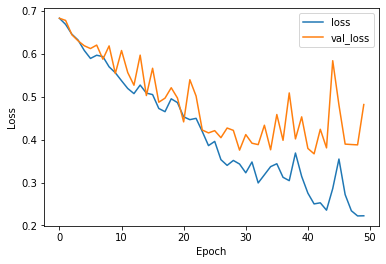

In [117]:
plt.plot(model7.history.history['loss'])
plt.plot(model7.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

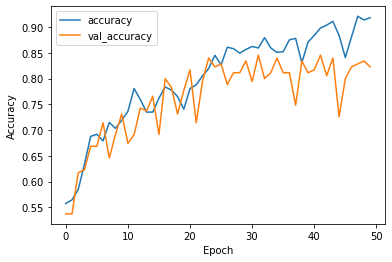

In [118]:
plt.plot(model7.history.history['accuracy'])
plt.plot(model7.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [119]:
mod7 = model7.evaluate(X_test, Y_test, verbose=0)
print(mod7[1])

0.8293333053588867


#### This accuracy score and performance across epochs is better than in the previous model and suggests I might have been overestimating how much information there was to be squeezed out of the images

#### Model8 is similar to model7, however when compiling model7 we used the 'adam' optimizer. Adam is a good all-purpose optimizer, however rmsprop is better suited to sparse data, which we might have - especially with when allowing padding. Let's try using the rmsprop optimizer and see if it improves the performance.

In [121]:
model8 = Sequential()
model8.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model8.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model8.add(Conv2D(filters = 16,  
                 kernel_size = 3, #note that the map here is smaller than above 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model8.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model8.add(Flatten())
model8.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model8.add(Dropout(0.3))
model8.add(Dense(1, activation = 'sigmoid'))

In [122]:
model8.compile(loss='binary_crossentropy', optimizer ='rmsprop', metrics=['accuracy'] )
model8.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 30ms/step - loss: 0.6956 - accuracy: 0.5516 - val_loss: 0.6895 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 15ms/step - loss: 0.6668 - accuracy: 0.5616 - val_loss: 0.6805 - val_accuracy: 0.6171
Epoch 3/50
14/14 [==============================] - 0s 15ms/step - loss: 0.6681 - accuracy: 0.5946 - val_loss: 0.6658 - val_accuracy: 0.5143
Epoch 4/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6604 - accuracy: 0.5989 - val_loss: 0.6652 - val_accuracy: 0.5257
Epoch 5/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6332 - accuracy: 0.6390 - val_loss: 0.7464 - val_accuracy: 0.5371
Epoch 6/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6507 - accuracy: 0.6318 - val_loss: 0.6505 - val_accuracy: 0.6000
Epoch 7/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6284 - accuracy: 0.6375 - val_loss: 0.6238 - val_accuracy: 0.7314
Epoch 8/50
14

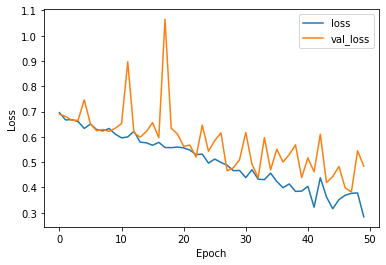

In [123]:
plt.plot(model8.history.history['loss'])
plt.plot(model8.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

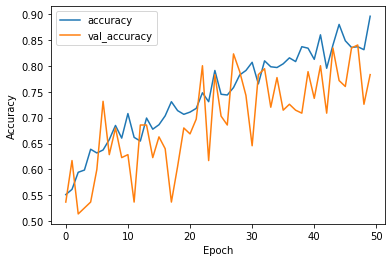

In [124]:
plt.plot(model8.history.history['accuracy'])
plt.plot(model8.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [125]:
mod8 = model8.evaluate(X_test, Y_test, verbose=0)
print(mod8[1])

0.7546666860580444


#### Model 8 performs worse at predicting labels in the test data than model 7, and the validation accuracy is very erratic - auggesting that Adam was a good choice of optimizer

#### In model 9 I reintroduce the dropout layer into the model architecture from model 7 to see if this can improve on what was a decent model. Here the Adam optimizer is used.

In [127]:
model9 = Sequential()
model9.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model9.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model9.add(Conv2D(filters = 16,  
                 kernel_size = 3, #note that the map here is smaller than above 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model9.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model9.add(Flatten())
model9.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model9.add(Dropout(0.3))
model9.add(Dense(1, activation = 'sigmoid'))

In [128]:
model9.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model9.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 27ms/step - loss: 0.6833 - accuracy: 0.5544 - val_loss: 0.7018 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6809 - accuracy: 0.5630 - val_loss: 0.6844 - val_accuracy: 0.5371
Epoch 3/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6752 - accuracy: 0.5716 - val_loss: 0.6835 - val_accuracy: 0.5429
Epoch 4/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6676 - accuracy: 0.5788 - val_loss: 0.6872 - val_accuracy: 0.5371
Epoch 5/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6597 - accuracy: 0.5702 - val_loss: 0.6652 - val_accuracy: 0.5086
Epoch 6/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6338 - accuracy: 0.6175 - val_loss: 0.6725 - val_accuracy: 0.5257
Epoch 7/50
14/14 [==============================] - 0s 14ms/step - loss: 0.6219 - accuracy: 0.6547 - val_loss: 0.6363 - val_accuracy: 0.6400
Epoch 8/50
14

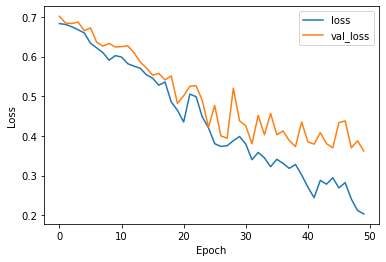

In [129]:
plt.plot(model9.history.history['loss'])
plt.plot(model9.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

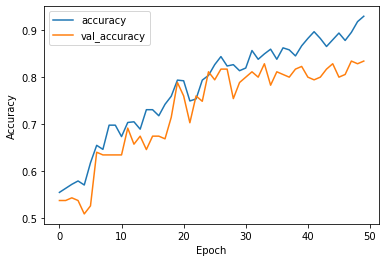

In [130]:
plt.plot(model9.history.history['accuracy'])
plt.plot(model9.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [131]:
mod9 = model9.evaluate(X_test, Y_test, verbose=0)
print(mod9[1])

0.8479999899864197


### Evaluation and Summary

#### In the previous section we've seen a lot of variations on a simple CNN model. We've augmented our data and experimented with the number of filters, the number of convolutionand max pooling layers, as well as whether to include a dropout layer or not. 

#### To evaluate these it would be tempting to present a chart showing the accuracy scores of each model, however this would miss the relationship between the training and validation data across across the model. While the accuracy scores have improved most (but not all) times that we've added complexity to the model the behaviour of the validation data has not been great in many of the models. In many models tha validation loss has plateaued very early on, while the loss on the training data has continued to fall, which suggests that the model is likely to be overfitting. In other models the validation loss and accuracy have been very volatile between epochs, or even increased after a certain point - again suggesting that the model is not to predict new data very well (check this).

#### Personally I am quite happy with model 9. It has an accuracy score of 0.85, meaning that it was able to predict 85% of labels in the test data correctly. Furthermore the loss and accuracy performance looks good, with both the validation and training loss decreasing across epochs and the validation loss plateauing much later than in other models - albeit the model was still probably trained for too many epochs. Conversely both training and validation accuracy scores increase relatively consistently - with the same caveat about the number of epochs.

#### If we compare the performance of model 9 to some of other decent models, we can see that the validation loss / accuracy is nowhere near as volatile as for model 8, while it plateaus maybe 10 epochs later than model 7.

#### In terms of application of the model, a quick googling brought up this article evaluating the performance of existing AI tools used to identify certain cancers.
https://www.frontiersin.org/articles/10.3389/fmed.2022.1018937/full#:~:text=The%20sensitivity%20and%20specificity%20of,99.1)%20(Supplementary%20Figures).

#### Although they use the language of sensitivity and specificity rather than accuracy, the typical percentage scores they find are somewhere between the high 80's and low 90's. The result for model 9 is comparable to this, suggesting that if I were to apply it to the full data set the result might be clinically useful.
